In [1]:
using Pkg
Pkg.activate("climate"; shared=true)

"/Users/imolk/Library/Julia/environments/climate/Project.toml"

In [2]:
# const SAVED_DIR = "/n/regal/pillai_lab/mrischard/saved/"
# const DATA_DIR = "/n/regal/pillai_lab/mrischard/TempModel/data/"
const SAVED_DIR = "/Volumes/Samsung250GB/saved/"
const DATA_DIR = "/Users/imolk/Documents/Harvard/Natesh/TempModel/data"

"/Users/imolk/Documents/Harvard/Natesh/TempModel/data"

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=150.0)
plt.rc("figure", figsize=(8,5))
plt.rc("savefig", dpi=150.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1185


In [4]:
using DataFrames
using TempModel
using Dates
using PDMats
using LinearAlgebra
using Printf
using Statistics
using StatsBase
using JSON

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1185
┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/TempModel/5V5SX.ji for TempModel [429a4ede-8e99-57b3-891e-c3971593d88c]
└ @ Base loading.jl:1185


In [5]:
ICAO = "KBDL"

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=DATA_DIR, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=DATA_DIR)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

k_nearest = 5
isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Float64,Float64
1,725080,14740,BRADLEY INTERNATIONAL AIRPORT,US,CT,KBDL,41.938,-72.683,57.9,1941,2015,-8.09103e6,5.1517e6
2,744910,14703,WESTOVER AFB/METROPOLITAN AIRPORT,US,MA,KCEF,42.2,-72.533,73.5,1941,2015,-8.07434e6,5.19099e6
3,725040,94702,IGOR I SIKORSKY MEMORIAL AIRPORT,US,CT,KBDR,41.158,-73.129,1.5,1942,2015,-8.14068e6,5.03567e6
4,725070,14765,THEODORE F GREEN STATE AIRPORT,US,RI,KPVD,41.722,-71.433,18.3,1942,2015,-7.95189e6,5.11943e6
5,725038,14714,STEWART INTERNATIONAL AIRPORT,US,NY,KSWF,41.5,-74.1,149.7,1942,2015,-8.24877e6,5.08637e6
6,725180,14735,ALBANY INTERNATIONAL AIRPORT,US,NY,KALB,42.743,-73.809,95.1,1946,2015,-8.21638e6,5.27294e6


In [6]:
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

In [7]:
# obtain the hourly temperature measurements for those stations
hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=DATA_DIR)
# mark station 1 as the test station
itest=1
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]

# emulate daily Tx/Tn measurement
hr_measure = Hour(17) # number between 0 and 24
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp]), 
    Tx=maximum(df[:temp])))
# add column to test data for TnTx (useful for plotting)
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours,ts_day,Tn,Tx
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,DateTime,Int64,Float64,Date,Float64,Float64
1,2015,1,1,0,0,0,-5.6,2015-01-01T00:00:00,1,0.0,2015-01-01,-10.6,0.0
2,2015,1,1,0,51,0,-5.0,2015-01-01T00:51:00,1,0.85,2015-01-01,-10.6,0.0
3,2015,1,1,1,51,0,-5.0,2015-01-01T01:51:00,1,1.85,2015-01-01,-10.6,0.0
4,2015,1,1,2,51,0,-7.2,2015-01-01T02:51:00,1,2.85,2015-01-01,-10.6,0.0
5,2015,1,1,3,51,0,-6.7,2015-01-01T03:51:00,1,3.85,2015-01-01,-10.6,0.0
6,2015,1,1,4,51,0,-10.6,2015-01-01T04:51:00,1,4.85,2015-01-01,-10.6,0.0


In [8]:
module Batch
    using ..TempModel
    import PyPlot; plt=PyPlot
    plt.rc("text", usetex=false)
    plt.rc("font", family="serif")
    plt.rc("font", serif="Palatino")
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
end

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/JLD/l8ijy.ji for JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1185
┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/AxisArrays/zm48T.ji for AxisArrays [39de3d68-74b9-583c-8d2d-e117c070f3a9]
└ @ Base loading.jl:1185


Main.Batch

In [9]:
function plot_pred(GPmodel, xlim, isdSubset; imputations=1, kwargs...)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR)
    test_data = test_trimmed
    train_data = hourly_train
    stations_metadata = isdSubset
    Batch.plot_predictive(
            nearby_pred, 
            test_data, train_data, stations_metadata, 
            local_time, 
            xlim; # xlim
            imputations=imputations,
            kwargs...)
    return nearby_pred
end

function print_diag(GPmodel)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR)
    test_data = test_trimmed
    train_data = hourly_train
    Batch.print_diagnostics(nearby_pred, test_data, train_data; ndraws=1000)
end
;

In [10]:
test_fw = Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20))
GPmodel = "matern"
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR);

In [11]:
plot_pred("matern", 
          xlim,
          isd_nearest_and_test,
          neighbours=false,
)
plt.ylim(-13, 17)
;

UndefVarError: UndefVarError: xlim not defined

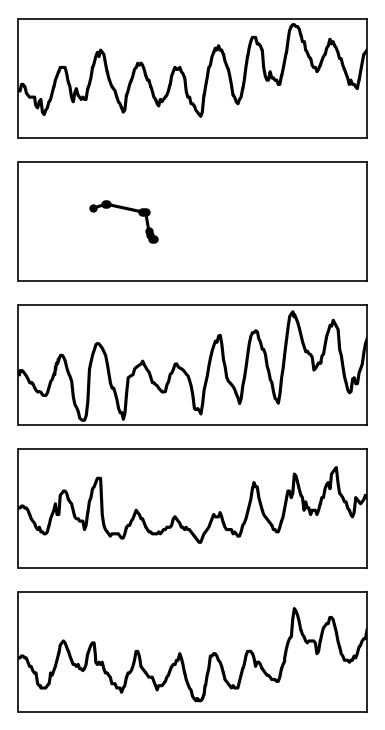

In [12]:
function subplot_neighbours(
        hourly_data, stations_metadata,
        local_time::Function,
        xlim::Tuple{DateTime,DateTime},
        stations::AbstractVector{String};
        timeseries=true,
        tntx=true,
        hr_measure::Hour=Hour(17),
        )

    data_subset = Batch.subset(hourly_data, xlim[1], xlim[2])
    station_indices = [findfirst(isequal(s), stations_metadata[:ICAO]) for s in stations]
    nstations = length(stations)
    ymin, ymax = extrema(data_subset[:temp])
    for (i,station) in enumerate(station_indices)
        if nstations > 1
            plt.subplot(nstations, 1, i)
        end
        sdata = data_subset[data_subset[:station].==station,:]
        if nrow(sdata) == 0
            @warn("no data for station $(station)")
            continue
        end
        ts = sdata[:ts]
        if timeseries
            if maximum(diff(ts)) > 6*Hour(1)
                plt.plot(local_time.(ts), sdata[:temp], ".-",
                         color="black",
                         label=stations_metadata[station,:ICAO],
                         )
            else
                plt.plot(local_time.(ts), sdata[:temp], 
                         color="black",
                         label=stations_metadata[station,:ICAO],
                         )
            end
        end
        if tntx
            Batch.plot_TnTx(sdata, station, hr_measure, local_time; linewidth=2)
        end
        plt.ylim(floor(ymin-1.0), ceil(ymax+1.0))
        plt.xlim(local_time.(xlim))
        ax = plt.gca()
        ax[:get_xaxis]()[:set_visible](false)
        ax[:get_yaxis]()[:set_visible](false)
    end

#     ts_true = test_subset[:ts]
#     temp_true = test_subset[:temp]
#     if truth
#         mean_true = mean(temp_true)
#         plt.plot(local_time.(ts_true), temp_true.-mean_true,
#                  zorder=15,
#                  marker="o",
#                  markersize=markersize,
#                  color=colour_truth, label="true hourly")
#     end
#     plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d"))
#     plt.gcf()[:autofmt_xdate]()
end
plt.gcf()[:set_size_inches](3,6)
xlim = (DateTime(2015,4,27,17,0,0), DateTime(2015,5,6,17,0,0))
subplot_neighbours(hourly_train, isd_nearest_and_test, 
    local_time, xlim,
    ["KALB", "KSWF", "KCEF", "KBDR", "KPVD"];
    tntx=false,
    )

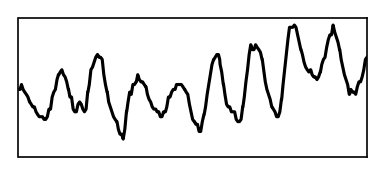

In [13]:
plt.gcf()[:set_size_inches](3,6/5)
subplot_neighbours(hourly_cat, isd_nearest_and_test, 
    local_time, xlim,
    ["KBDL"];
    tntx=false,
    timeseries=true,
    )
_ylim = plt.ylim()
plt.gcf()[:set_size_inches](3,6/5)
;

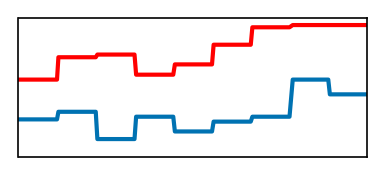

In [14]:
plt.gcf()[:set_size_inches](3,6/5)
subplot_neighbours(hourly_cat, isd_nearest_and_test, 
    local_time, xlim,
    ["KBDL"];
    tntx=true,
    timeseries=false,
    )
_ylim = plt.ylim()
plt.gcf()[:set_size_inches](3,6/5)
;

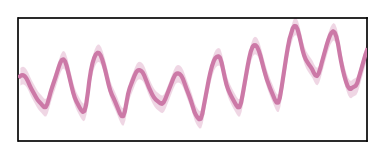

In [15]:
test_fw = Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20))
nearby_pred = plot_pred(
          "matern", 
          xlim,
          isd_nearest_and_test;
          neighbours=false,
          imputations=0,
          markersize=0,
          truth=false,
          intvl_width=0.8,
)
ax = plt.gca()
ax[:get_xaxis]()[:set_visible](false)
ax[:get_yaxis]()[:set_visible](false)
_ylim_nearby = plt.ylim()
wdow_true_mean = mean(Batch.subset(hourly_test, xlim[1], xlim[2])[:temp])
plt.ylim(_ylim[1]-wdow_true_mean, _ylim[2]-wdow_true_mean)
plt.gcf()[:set_size_inches](3,6/5)
;

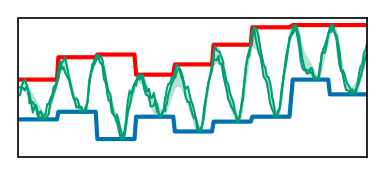

In [16]:
plt.gcf()[:set_size_inches](3,6/5)
subplot_neighbours(hourly_cat, isd_nearest_and_test, 
    local_time, xlim,
    ["KBDL"];
    tntx=true,
    timeseries=false,
    )
_ylim = plt.ylim()
let
    stan_fw = Batch.get_window(40)
    local chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR)
        temp_impute = Batch.get_temperatures_reparam(chains)

    plt.gcf()[:set_size_inches](3,6/5)
    temp_impute = Batch.get_temperatures_reparam(chains)
    Batch.plot_imputations(_ts, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
end

In [17]:
function plot_imput(GPmodel, isdSubset, window_num)
    stan_fw = Batch.get_window(window_num)
    hr_measure = Hour(17)
    chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR)
    temp_impute = Batch.get_temperatures_reparam(chains)
    test_subsubset = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)

    Batch.plot_truth(test_subsubset, stan_fw, hr_measure, local_time; tntx=true)
    Batch.plot_imputations(test_subsubset[:ts], temp_impute, local_time; plot_mean=false, impt_indices=[250,500])

    plt.legend(loc="best", fontsize="small")
    plt.title(@sprintf("Imputed %s data", titlecase(lowercase(isdSubset[itest,:NAME]))))
    plt.gcf()[:autofmt_xdate]()

#     plt.xlim(Date(2015,5,2), Date(2015,5,5))
end
;

In [18]:
plot_imput("matern", isd_nearest_and_test, 40)
plt.xlim(local_time.(xlim))

┌ Warning: broadcast will default to iterating over its arguments in the future. Wrap arguments of
│ type `x::Main.Batch.FittingWindow` with `Ref(x)` to ensure they broadcast as "scalar" elements.
│   caller = ip:0x0
└ @ Core :-1


MethodError: MethodError: no method matching plot_truth(::DataFrame, ::Main.Batch.FittingWindow, ::Hour, ::typeof(local_time); tntx=true)
Closest candidates are:
  plot_truth(::DataFrame, ::Main.Batch.FittingWindow, ::Hour, ::Function; markersize) at /Users/imolk/Documents/Harvard/Natesh/TempModel/src/plot_diagnostics.jl:49 got unsupported keyword argument "tntx"

In [19]:
window_num = 1
stan_fw = Batch.get_window(window_num)
hr_measure = Hour(17)
@time chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR)
@show size(chains)
;

  1.939887 seconds (5.67 M allocations: 188.046 MiB, 2.87% gc time)
size(chains) = (1000, 665, 4)


In [20]:
ts_year = hourly_test[:ts]
buffer_year = fill(Millisecond(-1), length(ts_vec))
temp_posterior_mean = fill(0.0, length(ts_vec))

for window_num in 1:119
    print(",",window_num)
    stan_fw = Batch.get_window(window_num)
    hr_measure = Hour(17)
    local chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, SAVED_DIR)
    buff = min.(_ts.-minimum(_ts), maximum(_ts).-_ts)
    ifirst = findfirst(isequal(_ts[1]), ts_year)
    ilast = ifirst+length(_ts)-1
    temp_impute = Batch.get_temperatures_reparam(chains)
    window_posterior_mean = vec(mean(temp_impute.data; dims=[1,3]))
    
    is_better = findall(buff .> buffer_year[ifirst:ilast])
    temp_posterior_mean[(ifirst:ilast)[is_better]] = window_posterior_mean[is_better]
    buffer_year[(ifirst:ilast)[is_better]] = buff[is_better]
end

UndefVarError: UndefVarError: ts_vec not defined

In [21]:
mean(temp_error) # this is huge!

UndefVarError: UndefVarError: temp_error not defined

In [22]:
using JLD
nearby_path = "/Volumes/Samsung250GB/saved/predictions_from_nearby/matern/KBDL/725080_14740_KBDL_2015-07-14_to_2015-09-25.jld"
nearby_pred=load(nearby_path)["nearby_pred"];

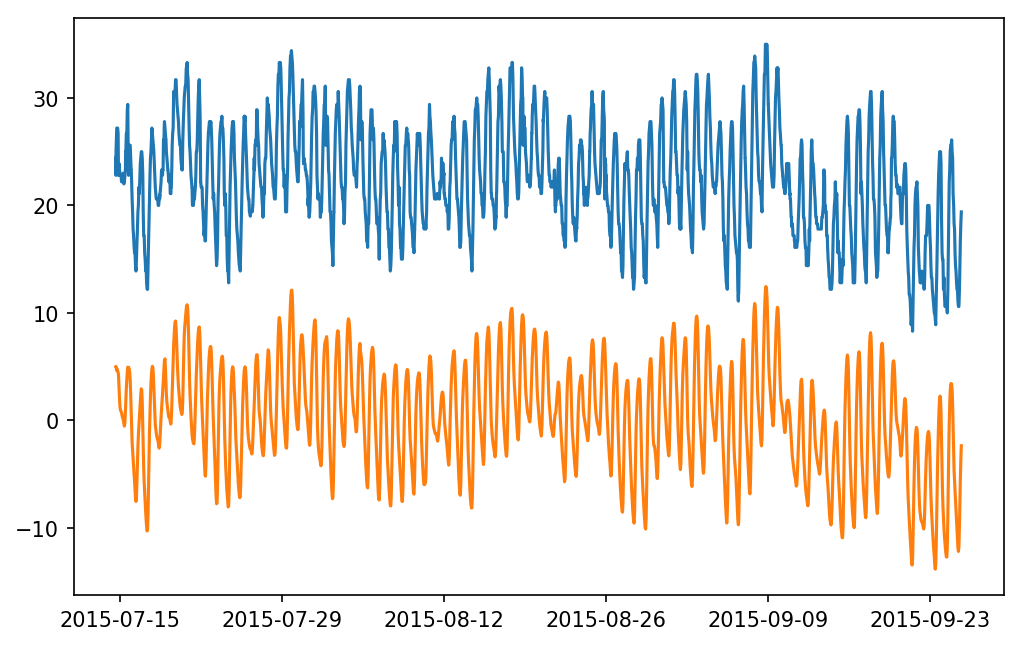

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x134aa8dd8>

In [23]:
ifirst = findfirst(isequal(nearby_pred.ts[1]), hourly_test[:ts])
ilast = ifirst + length(nearby_pred.ts) - 1
plt.plot(hourly_test[:ts][ifirst:ilast], hourly_test[:temp][ifirst:ilast])
plt.plot(nearby_pred.ts, nearby_pred.μ)

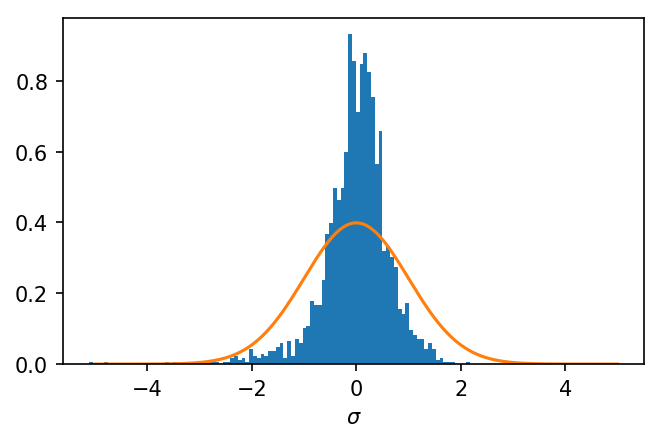

(mean(nearby_sigma), std(nearby_sigma)) = (-0.0003530469681776225, 0.6389654764223305)


In [24]:
plt.gcf()[:set_size_inches](5, 3)
using Distributions
μ, Σ = nearby_pred.μ, nearby_pred.Σ
nobsv = size(Σ, 1)
centering = Matrix(1.0I, nobsv, nobsv) .- (1.0/nobsv)
Σ_centered = centering * Σ.mat * centering
ifirst = findfirst(isequal(nearby_pred.ts[1]), hourly_test[:ts])
ilast = ifirst + length(nearby_pred.ts) - 1
nearby_error = hourly_test[ifirst:ilast,:temp] .- μ
nearby_error .-= mean(nearby_error)
nearby_sigma = nearby_error ./ sqrt.(diag(Σ_centered))
plt.plt[:hist](nearby_sigma, bins=100, normed=true)
xx = range(-5, stop=5, length=1000)
plt.plot(xx, pdf.(Normal(), xx))
plt.xlabel(L"\sigma")
@show mean(nearby_sigma), std(nearby_sigma) # should be 0,1
;

In [27]:
nearby_dir = joinpath(SAVED_DIR, "predictions_from_nearby/matern/KBDL/")
for nearby_file in readdir(nearby_dir)
    nearby_path = joinpath(nearby_dir, nearby_file)
    nearby_pred=load(nearby_path)["nearby_pred"]
    μ, Σ = nearby_pred.μ, nearby_pred.Σ
    nobsv = size(Σ, 1)
    centering = Matrix(1.0I, nobsv, nobsv) .- (1.0/nobsv)
    Σ_centered = centering * Σ.mat * centering
    ifirst = findfirst(isequal(nearby_pred.ts[1]), hourly_test[:ts])
    ilast = ifirst + length(nearby_pred.ts) - 1
    nearby_error = hourly_test[ifirst:ilast,:temp] .- μ
    nearby_error .-= mean(nearby_error)
    nearby_sigma = nearby_error ./ sqrt.(diag(Σ_centered))
    @show mean(nearby_sigma), std(nearby_sigma) # should be 0,1
end

┌ Warning: Deprecated syntax `implicit assignment to global variable `μ``.
│ Use `global μ` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `Σ``.
│ Use `global Σ` instead.
└ @ nothing none:0


(mean(nearby_sigma), std(nearby_sigma)) = (-0.0013185727911547336, 0.7382975907199559)
(mean(nearby_sigma), std(nearby_sigma)) = (0.0003124106364819369, 0.675360587211928)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.0016849203250241145, 0.6355064443025054)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.0005725991225809974, 0.6676715560915651)
(mean(nearby_sigma), std(nearby_sigma)) = (0.001659252030585719, 0.6206511395607057)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.002426724817923779, 0.6347100521489972)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.002330833753281088, 0.5927180685815564)
(mean(nearby_sigma), std(nearby_sigma)) = (0.0015471047202309824, 0.6377620071722953)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.0003530469681776225, 0.6389654764223305)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.0003762781535794098, 0.5944006742386483)
(mean(nearby_sigma), std(nearby_sigma)) = (-8.640487979303823e-5, 0.5565590406436746)
(mean(nearby_sigma), std(nearby_sigma)) = (-0.00040

In [180]:
√(mean(nearby_pred.Σ.mat))

20.249917660012333

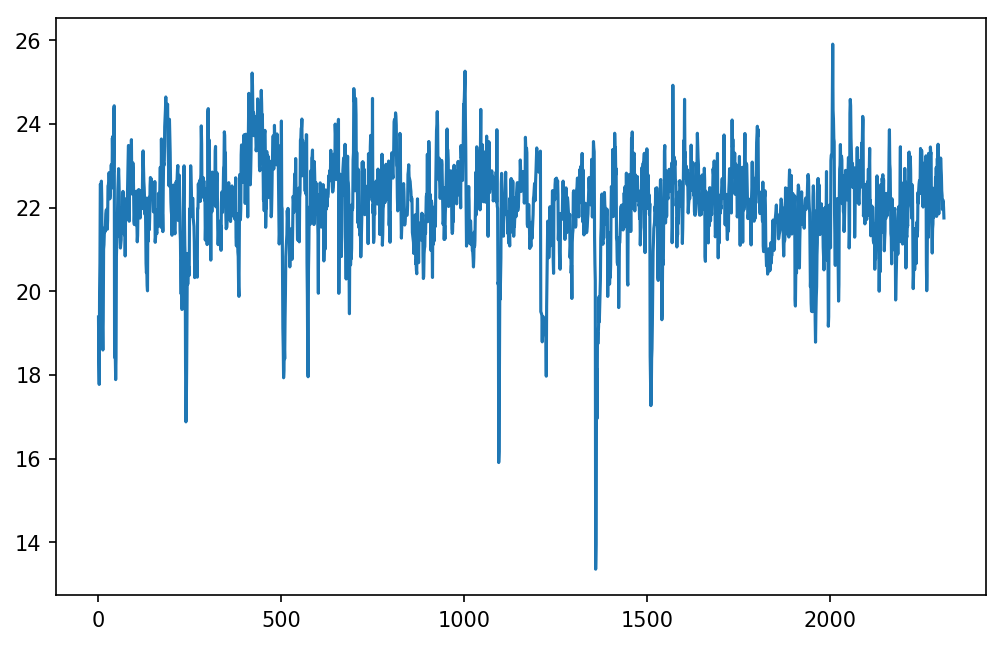

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1333e3390>

In [181]:
plt.plot(hourly_test[:temp][ifirst:ilast] .- nearby_pred.μ)

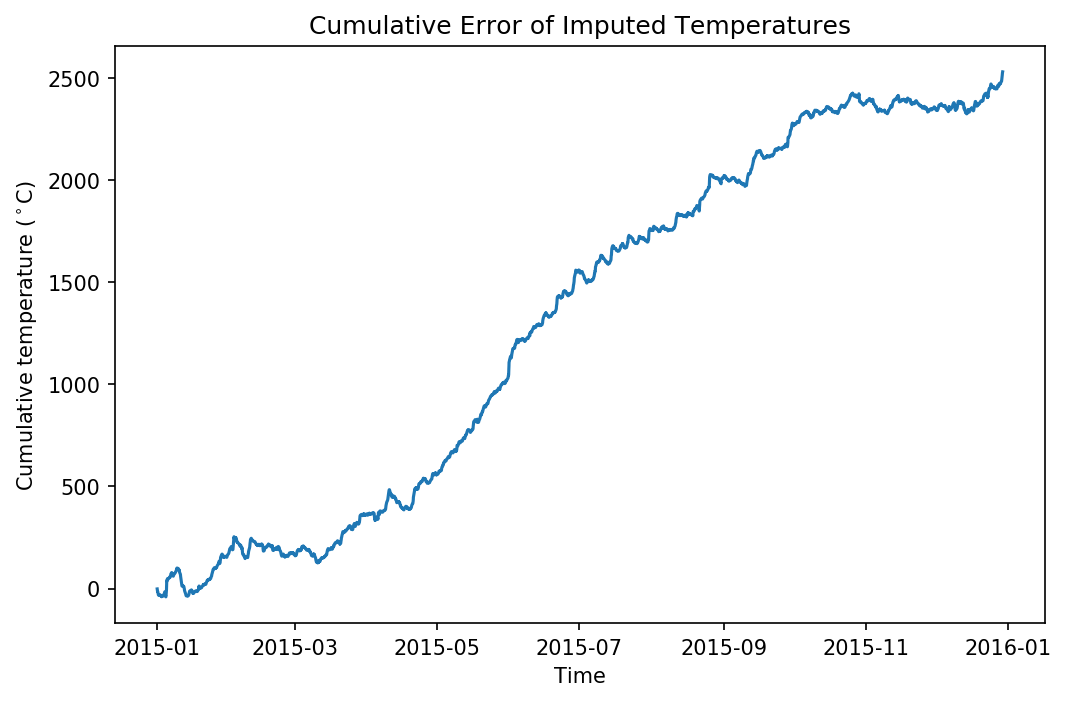

PyObject Text(39,0.5,'Cumulative temperature $(^\\circ\\mathrm{C})$')

In [182]:
temp_error = temp_posterior_mean .- hourly_test[:temp]
have_imputations = buffer_year .>= Millisecond(0)
plt.plot(ts_year[have_imputations], cumsum(temp_error[have_imputations]))
plt.title("Cumulative Error of Imputed Temperatures")
plt.xlabel("Time")
plt.ylabel(L"Cumulative temperature $(^\circ\mathrm{C})$")

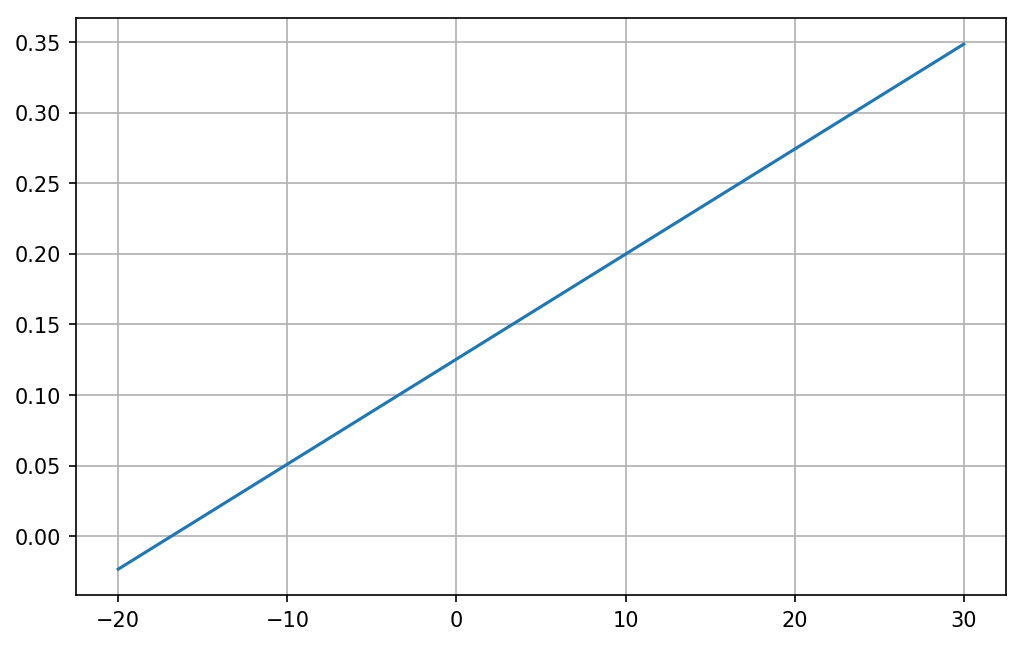

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x133d46518>

In [183]:
mylinreg(x, y) = hcat(fill!(similar(x), 1), x) \ y
βhat = mylinreg(temp_posterior_mean, temp_error)
xx = range(-20,stop=30,length=1000)
yy = βhat[1] .+ βhat[2].*xx
temp_error = temp_posterior_mean .- hourly_test[:temp]
# plt.plot(temp_posterior_mean, temp_error, ".", alpha=0.1, color="black")
plt.grid(true)
plt.plot(xx, yy)

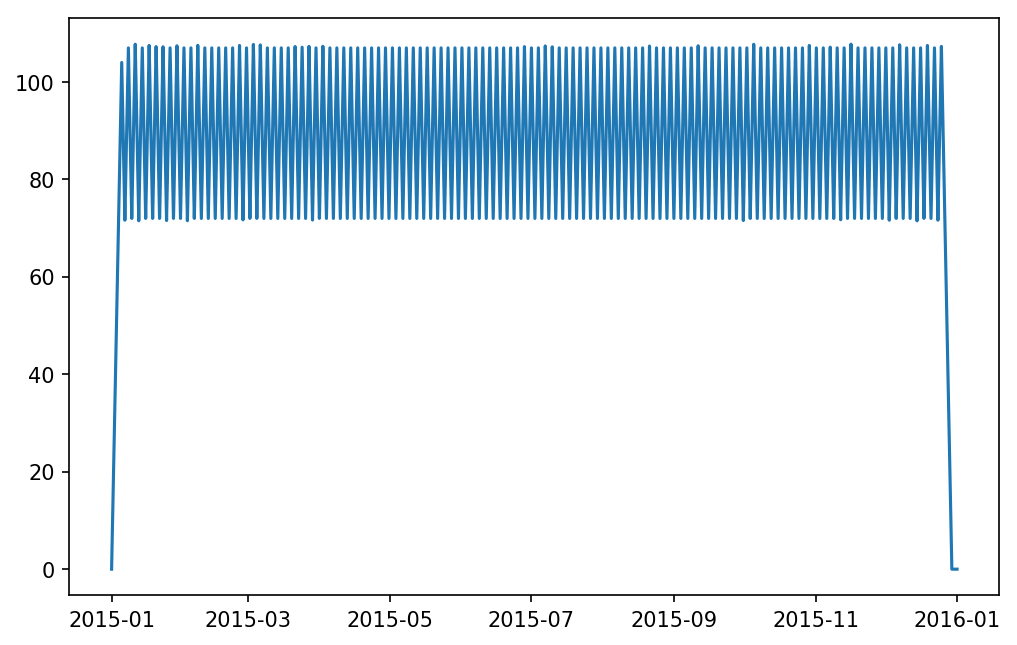

In [184]:
plt.plot(ts_year, buffer_year ./ convert(Millisecond, Hour(1)))
;

In [185]:
function true_mean_day(hourly, hr_measure)
    ts, temp = hourly[:ts], hourly[:temp]
    temp_mid = midpoints(temp)
    ts_mid, ts_diff = midpoints(ts), diff(ts)
    ts_mid_day = TempModel.measurement_date.(ts_mid, hr_measure)
    days = sort(unique(ts_mid_day))[1:end]
    ndays = length(days)
    means_by_day = Float64[]
    total_duration = Float64[]
    for iday in 1:ndays
        day = days[iday]
        sub = ts_mid_day .== day
        ts_sub, diff_sub = ts_mid[sub], ts_diff[sub]
        weights = Weights(diff_sub ./ Millisecond(1))
        temp_sub = temp_mid[sub]
        mean_temp = mean(temp_sub, weights)
        push!(means_by_day, mean_temp)
        push!(total_duration, sum(diff_sub) ./ convert(Millisecond, Hour(1)))
    end
    return days, means_by_day, total_duration
end

days, means_by_day, total_duration = true_mean_day(hourly_test, hr_measure)
@show mean(means_by_day, Weights(total_duration))
;

mean(means_by_day, Weights(total_duration)) = 10.805544520358984


In [186]:
GPmodel = "matern"
out_save_dir = joinpath(SAVED_DIR, "daily_mean", GPmodel)
mkpath(out_save_dir)
filepath = joinpath(out_save_dir, "daily_means_$(ICAO).json")
open(filepath, "r") do io
    global all_posteriors = JSON.parse(io)
end

days_vec, day_means, day_cov, day_buffer, buffer_cov = Batch.daily_best(all_posteriors);

In [187]:
total_duration_overlap = total_duration[1:end-3]
yearly_mean = sum(day_means .* total_duration_overlap) / sum(total_duration_overlap)
@printf("yearly posterior mean: %6.3f\n", yearly_mean)
yearly_var = (total_duration_overlap'*day_cov*total_duration_overlap) / sum(total_duration_overlap)^2
yearly_std = √(yearly_var)
@printf("yearly posterior std:  %6.3f\n", √yearly_var)

yearly posterior mean: 11.019
yearly posterior std:   0.027


In [188]:
yearly_true_mean = mean(means_by_day[1:end-3], Weights(total_duration_overlap))
@show yearly_true_mean

yearly_true_mean = 10.86945386316424


10.86945386316424

In [189]:
sigma = (yearly_mean - yearly_true_mean) / yearly_std

5.445833697627923

In [191]:
sqrt(
    (total_duration_overlap' 
     * day_cov
     *total_duration_overlap) 
    / sum(total_duration_overlap)^2
)

0.027468785071496405

In [193]:
systematic_cov(kij) = kij == 0 ? 0.008 : kij
sqrt(
    (total_duration_overlap' 
     * systematic_cov.(day_cov)
     *total_duration_overlap) 
    / sum(total_duration_overlap)^2
)

0.09179882809494753